## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import random
import sklearn.model_selection as skl
import tensorflow as tf
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten 
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, roc_curve, auc  
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import binarize

# fix random_state for reproducibility
random_state = 42

# plotting style
plt.style.use('ggplot')

# fix number of epochs for model training
num_epochs = 50

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3, random_state = random_state)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
89645,00022260_003.png,No Finding,3,22260,54,F,PA,2542,2434,0.143,0.143,NaN,/data/images_010/images/00022260_003.png
47446,00012048_007.png,Infiltration|Mass|Nodule,7,12048,65,M,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00012048_007.png
57963,00014352_005.png,No Finding,5,14352,6,M,PA,2992,2033,0.143,0.143,NaN,/data/images_007/images/00014352_005.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda diseases: diseases.split('|')).tolist())))
labels = [label for label in labels if label != 'No Finding']
for label in labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
    print('%s: %d'%(label, int(all_xray_df[label].sum())))

Atelectasis: 11559
Cardiomegaly: 2776
Consolidation: 4667
Edema: 2303
Effusion: 13317
Emphysema: 2516
Fibrosis: 1686
Hernia: 227
Infiltration: 19894
Mass: 5782
Nodule: 6331
Pleural_Thickening: 3385
Pneumonia: 1431
Pneumothorax: 5302


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda df: '1' if df['Pneumonia']== 1.0 else '0', axis=1)
all_xray_df.sample(3, random_state = random_state)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
89645,00022260_003.png,No Finding,3,22260,54,F,PA,2542,2434,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
47446,00012048_007.png,Infiltration|Mass|Nodule,7,12048,65,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0
57963,00014352_005.png,No Finding,5,14352,6,M,PA,2992,2033,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Create your training and testing data:

In [5]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    train_data, val_data = skl.train_test_split(vargs, 
                                   test_size = 0.2, 
                                   stratify = vargs['pneumonia_class'], 
                                                random_state = random_state)
    
    # extract the index for all pneumonia cases from the train_data and convert to list
    pos_ind = train_data[train_data['pneumonia_class'] == '1'].index.tolist()

    # extract the index for all non-pneumonia cases from the train_data and convert to list
    neg_ind = train_data[train_data['pneumonia_class'] == '0'].index.tolist()

    # randomly sample the neg_ind list to be of the same length as pos_ind
    # use seed for reproducibility
    random.seed(random_state)
    sampled_neg_ind = random.sample(neg_ind, len(pos_ind))

    # extract equal number of pneumonia and non-pneumonia cases
    train_data = train_data.loc[pos_ind + sampled_neg_ind]
    
    val_pos_ind = val_data[val_data['pneumonia_class'] == '1'].index.tolist()
    val_neg_ind = val_data[val_data['pneumonia_class'] == '0'].index.tolist()

    # make the number non-pneumonia data equal 4 times as big as the pneumonia sample.
    # randomly sample the val_neg_ind list to be of the same length as val_pos_ind
    
    sampled_val_neg_ind = random.sample(val_neg_ind, 4*len(val_pos_ind))
    val_data = val_data.loc[val_pos_ind + sampled_val_neg_ind]    
    
    return train_data, val_data

In [6]:
# split the dataset using the create_splits function
train_data, val_data = create_splits(all_xray_df)

In [7]:
# Check the fraction of positive cases in the training dataset
train_data[train_data['pneumonia_class'] == '1']['pneumonia_class'].count()/len(train_data)

0.5

Remarks: training dataset is balanced 1:1

In [8]:
# Check the fraction of positive cases in the validation dataset
val_data[val_data['pneumonia_class'] == '1']['pneumonia_class'].count()/len(val_data)

0.2

Remarks: Validation dataset has 20% prevalence of pneumonial to mirror real clinical scenario

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [9]:
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    train_idg = ImageDataGenerator(rescale=1.0/vargs,
                      horizontal_flip = True, 
                      vertical_flip = False, 
                      height_shift_range= 0.1, 
                      width_shift_range=0.1, 
                      rotation_range=20, 
                      shear_range = 0.1,
                      zoom_range=0.1)
    
    val_idg = ImageDataGenerator(rescale=1.0/vargs)
    
    return train_idg, val_idg

In [10]:
train_idg, val_idg = my_image_augmentation(255)

In [11]:
image_size = (224, 224) 

In [12]:
def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    train_gen = train_idg.flow_from_dataframe(dataframe=vargs, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = image_size, 
                                         batch_size = 32,
                                         seed= random_state
                                         )    # what should inform the batch_size to use?

    return train_gen


def make_val_gen(vargs):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    val_gen = val_idg.flow_from_dataframe(dataframe=vargs, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = image_size, 
                                         batch_size = len(val_data), 
                                         seed = random_state)     
    return val_gen

In [13]:
train_gen = make_train_gen(train_data)
val_gen = make_val_gen(val_data)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [14]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

In [15]:
len(valX)

1430

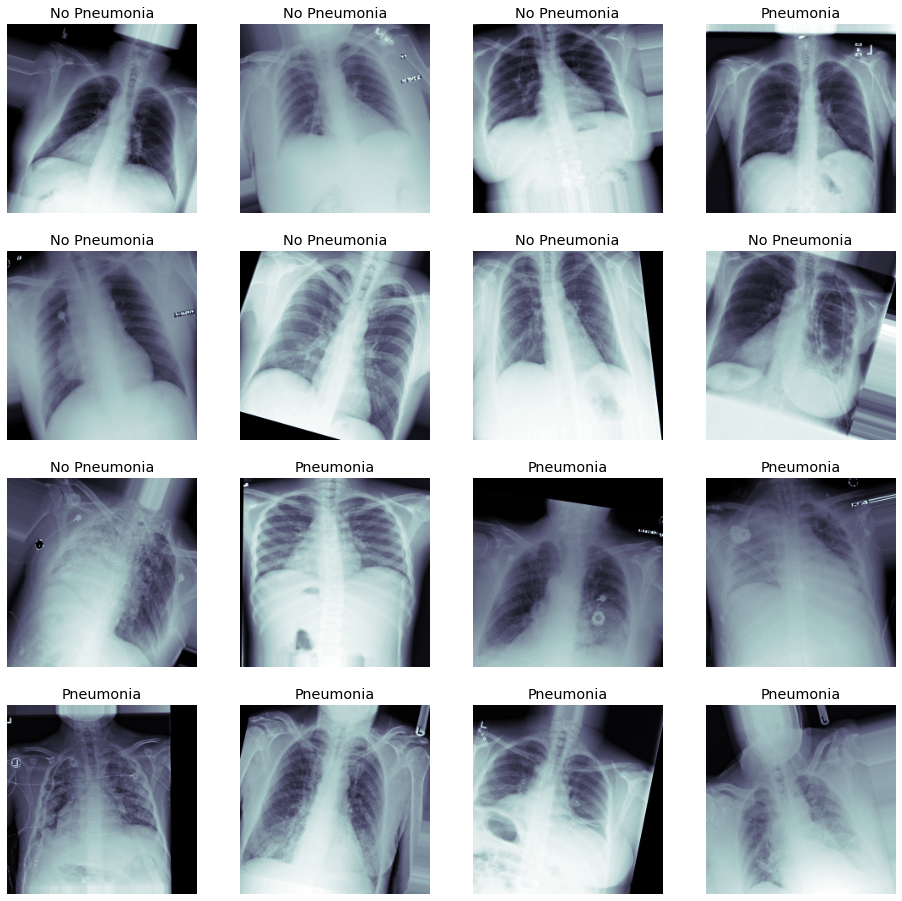

In [16]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [17]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
    
    return vgg_model


In [18]:
vgg_model = load_pretrained_model()
vgg_model.summary()

553467904/553467096 [==============================] - 6s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [19]:
def build_my_model(model, end_layer_freeze_at = -1, specific_layer = None, fc_list = []):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    if specific_layer == None:        
        for layer in model.layers[0:end_layer_freeze_at]:
            layer.trainable = False
        for layer in model.layers:    
            print(layer.name, layer.trainable)
    
    #if specific_layer != False:
    else:
        for ind, layer in enumerate(model.layers):
            if ind != specific_layer: 
                layer.trainable = False
        for layer in model.layers:
            print(layer.name, layer.trainable)

    # initialize the model
    model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a convolutional layer.
    model.add(Flatten())
    
    if len(fc_list) > 0:
        for i, num in enumerate(fc_list):    
            model.add(Dropout(0.5))
            model.add(Dense(num, activation='relu'))
        
    model.add(Dense(1, activation='sigmoid'))     
    
    # compiling the model
    model.compile(optimizer=Adam(lr=1e-4), 
                     loss='binary_crossentropy', 
                     metrics=['binary_accuracy'])    
    
    return model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

#### 1. Using only last layer; no adding drop-out;  no FC-layers

In [20]:
## using only the last output layer, no dropout, no FC-layer
## running for 10 epochs to see how if any learning occurs:
my_model = build_my_model(vgg_model)
my_model.fit_generator(train_gen, 
                       validation_data = (valX, valY), 
                       epochs = 10)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool True
Epoch 1/10
72/72 [==============================] - 78s 1s/step - loss: 0.6961 - binary_accuracy: 0.5406 - val_loss: 0.8552 - val_binary_accuracy: 0.2720
Epoch 2/10
72/72 [==============================] - 64s 888ms/step - loss: 0.6730 - binary_accuracy: 0.5878 - val_loss: 0.7550 - val_binary_accuracy: 0.4692
Epoch 3/10
72/72 [==============================] - 64s 887ms/step - loss: 0.6594 - binary_accuracy: 0.6092 - val_loss: 0.6869 - val_binary_accuracy: 0.5594
Epoch 4/10
72/72 [==============================] - 64s 884ms/step - loss: 0.6594 - binary_accuracy: 0.6131 - val_loss: 0.6457 - val_binary_accuracy: 0.6217
Epoch 5/10
72/72 [=======

In [21]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

"""
def checkpoint(model):
    weight_path="{}_{}.best.hdf5".format('pneumonia_class', model)

    checkpoint = ModelCheckpoint(weight_path, 
                                  monitor= 'val_loss', 
                                  verbose=1, 
                                  save_best_only=True, 
                                  mode= 'min', 
                                  save_weights_only = True)

    early = EarlyStopping(monitor= 'val_loss', 
                           mode= 'min', 
                           patience=10)

    callbacks_list = [checkpoint, early]
    
    return weight_path, callbacks_list
 """   

'\ndef checkpoint(model):\n    weight_path="{}_{}.best.hdf5".format(\'pneumonia_class\', model)\n\n    checkpoint = ModelCheckpoint(weight_path, \n                                  monitor= \'val_loss\', \n                                  verbose=1, \n                                  save_best_only=True, \n                                  mode= \'min\', \n                                  save_weights_only = True)\n\n    early = EarlyStopping(monitor= \'val_loss\', \n                           mode= \'min\', \n                           patience=10)\n\n    callbacks_list = [checkpoint, early]\n    \n    return weight_path, callbacks_list\n '

In [22]:
weight_path="{}_my_model.best.hdf5".format('pneumonia_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [23]:
## train your model

# Todo
hist = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = num_epochs, 
                           callbacks = callbacks_list)

Epoch 1/50
72/72 [==============================] - 74s 1s/step - loss: 0.6375 - binary_accuracy: 0.6424 - val_loss: 0.6324 - val_binary_accuracy: 0.6406

Epoch 00001: val_loss improved from inf to 0.63243, saving model to pneumonia_class_my_model.best.hdf5
Epoch 2/50
72/72 [==============================] - 64s 890ms/step - loss: 0.6366 - binary_accuracy: 0.6432 - val_loss: 0.6775 - val_binary_accuracy: 0.5797

Epoch 00002: val_loss did not improve from 0.63243
Epoch 3/50
72/72 [==============================] - 65s 904ms/step - loss: 0.6340 - binary_accuracy: 0.6485 - val_loss: 0.7150 - val_binary_accuracy: 0.5364

Epoch 00003: val_loss did not improve from 0.63243
Epoch 4/50
72/72 [==============================] - 64s 888ms/step - loss: 0.6329 - binary_accuracy: 0.6376 - val_loss: 0.6637 - val_binary_accuracy: 0.5965

Epoch 00004: val_loss did not improve from 0.63243
Epoch 5/50
72/72 [==============================] - 64s 890ms/step - loss: 0.6293 - binary_accuracy: 0.6467 - val_l

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [24]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, verbose = True)

1430/1430 [==============================] - 13s 9ms/step


### Visualizations and evaluations

In [25]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, ax = plt.subplots(1,1, figsize = (7, 7))    
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    ax.plot(fpr, tpr, label = 'AUC = %0.3f'  % (auc(fpr, tpr)))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    #ax.set_xlim([0, 1])
    #ax.set_ylim([0, 1])
    ax.legend(loc = 'best')
    return

## what other performance statistics do you want to include here besides AUC? 

def f1_plot(t_y, p_y):
        
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    f1s = [f1_score(t_y, binarize(p_y, ind)) for ind in thresholds]
    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    ax.plot(thresholds, f1s, label = 'F1 Score')
    ax.legend()
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1 Score')
    ax.set_title('F1_score vs Threshold')

    return

def prec_recall_plot(t_y, p_y):
# Todo
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    ax.plot(recall, precision)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    return
    
#Also consider plotting the history of your model training:
def plot_history(history):        
    # Todo
    x_values = np.arange(0, len(history.history["loss"]))
    metrics = ["loss", "val_loss", "binary_accuracy", "val_binary_accuracy"]
    labels = ["train_loss", "val_loss", "train_acc", "val_acc"]
    markers = ['k-', 'r-', 'b-', 'g-']
    plt.figure(figsize=(7,7))
    for ind, metric in enumerate(metrics):
        plt.plot(x_values, history.history[metric], markers[ind] , label=labels[ind])
    plt.title("Training & Validation Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="best")    
    return

# function to calculate the F1 score
def calc_f1(precision,recall):
    return 2*(precision*recall)/(precision+recall)

# function to obtain threshold at maximum f1_score => best threshold

def best_threshold(precision, recall):
    
    """
    This function finds the threshold at maximum f1_score computed 
    from input precision and recall. It prints the threshold and the 
    corresponding precision and recall.   
    
    """   
    f1_score = calc_f1(precision, recall)
    idx_max_f1_score = np.nanargmax(f1_score) # find the index at maximum f1_score
    best_threshold = thresholds[idx_max_f1_score]
    # print corresponding threshold, precision and recall
    print('Threshold that maximized f1_score is: %.3f'%best_threshold)
    print('Corresponding Precision is: %.3f'%precision[idx_max_f1_score])
    print('Recall is: %.2f'%recall[idx_max_f1_score])
    
    return best_threshold

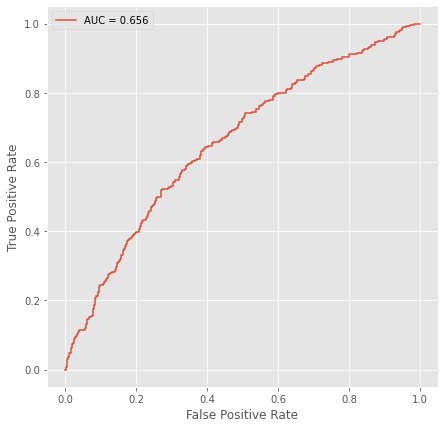

In [26]:
plot_auc(valY, pred_Y)

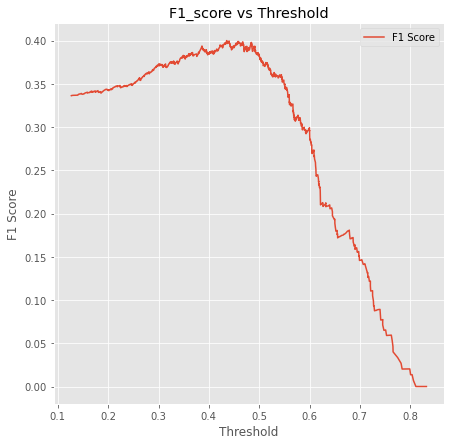

In [27]:
f1_plot(valY, pred_Y)

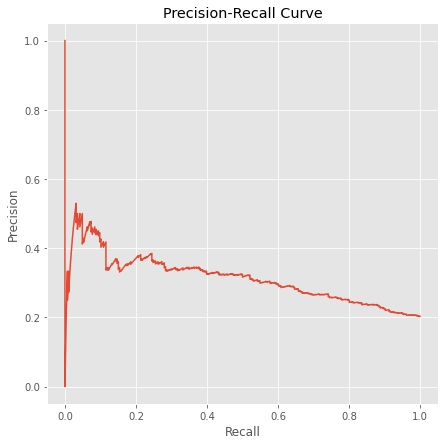

In [28]:
prec_recall_plot(valY, pred_Y)

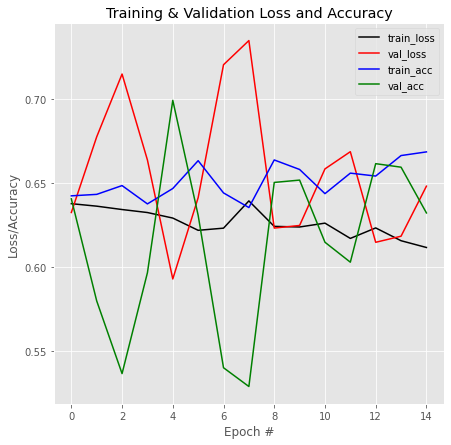

In [29]:
plot_history(hist)

#### Comments 

Model appears to be unstable with little learning. Need to add droupout and full-connected layer(s)

### Trying out different architectures

#### 2. Using only last layer, adding drop-out, and connecting 1 FC-layers

In [30]:
vgg_model1 = load_pretrained_model()
vgg_model1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [31]:
## using only the last output layer, dropout and 1 FC-layer
## running for 10 epochs to see how if any learning occurs:
my_model1 = build_my_model(vgg_model1,
                           end_layer_freeze_at = -1, 
                           specific_layer = None, 
                           fc_list = [1024])
#my_model1.fit_generator(train_gen, 
#                       validation_data = (valX, valY), 
#                       epochs = int(num_epochs/4))

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool True


In [32]:
weight_path1="{}_my_model1.best.hdf5".format('pneumonia_class')

checkpoint1 = ModelCheckpoint(weight_path1, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early1 = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list1 = [checkpoint1, early1]

In [33]:
hist1 = my_model1.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = num_epochs, 
                           callbacks = callbacks_list1)

Epoch 1/50
72/72 [==============================] - 72s 998ms/step - loss: 0.8133 - binary_accuracy: 0.5393 - val_loss: 0.7770 - val_binary_accuracy: 0.5077

Epoch 00001: val_loss improved from inf to 0.77704, saving model to pneumonia_class_my_model1.best.hdf5
Epoch 2/50
72/72 [==============================] - 64s 894ms/step - loss: 0.7158 - binary_accuracy: 0.5760 - val_loss: 0.5995 - val_binary_accuracy: 0.7035

Epoch 00002: val_loss improved from 0.77704 to 0.59945, saving model to pneumonia_class_my_model1.best.hdf5
Epoch 3/50
72/72 [==============================] - 65s 898ms/step - loss: 0.6752 - binary_accuracy: 0.5913 - val_loss: 0.7014 - val_binary_accuracy: 0.5559

Epoch 00003: val_loss did not improve from 0.59945
Epoch 4/50
72/72 [==============================] - 64s 888ms/step - loss: 0.6740 - binary_accuracy: 0.5978 - val_loss: 0.7791 - val_binary_accuracy: 0.4636

Epoch 00004: val_loss did not improve from 0.59945
Epoch 5/50
72/72 [==============================] - 64

In [34]:
my_model1.load_weights(weight_path1)
pred_Y1 = my_model1.predict(valX, verbose = True)

1430/1430 [==============================] - 13s 9ms/step


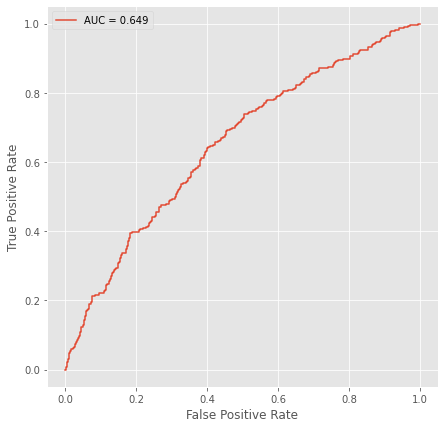

In [35]:
plot_auc(valY, pred_Y1)

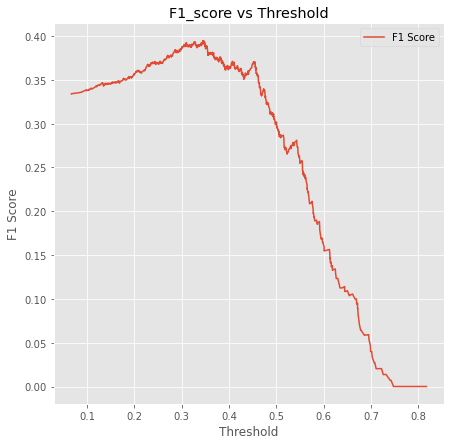

In [36]:
f1_plot(valY, pred_Y1)

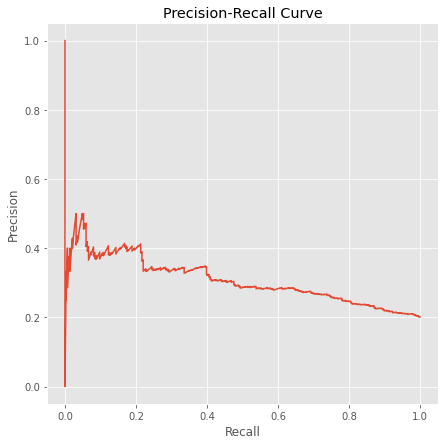

In [37]:
prec_recall_plot(valY, pred_Y1)

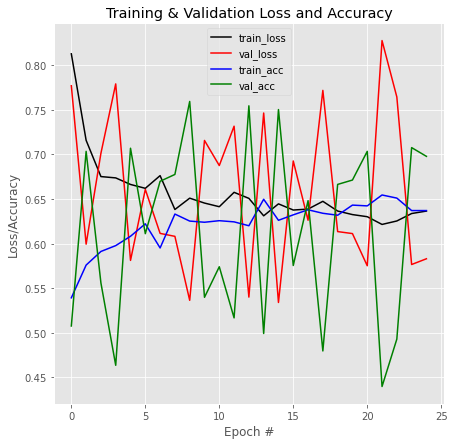

In [38]:
plot_history(hist1)

#### Comments: 

Model appears a bit unstable but promising. Need to add more dropout and FC layer(s)

#### 3. Using only the last layer, adding drop-out, and connecting 3 FC-layers

In [39]:
vgg_model2 = load_pretrained_model()
vgg_model2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [40]:
## using only the last output layer more dropouts and connecting 3 FC layers
## running for 10 epochs to see how if any learning occurs:
my_model2 = build_my_model(vgg_model2,
                           end_layer_freeze_at = -1, 
                           specific_layer = None, 
                           fc_list = [1024, 512, 256])
#my_model2.fit_generator(train_gen, 
#                       validation_data = (valX, valY), 
#                       epochs = int(num_epochs/4))

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool True


In [41]:
weight_path2="{}_my_model2.best.hdf5".format('pneumonia_class')

checkpoint2 = ModelCheckpoint(weight_path2, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early2 = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list2 = [checkpoint2, early2]

In [42]:
hist2 = my_model2.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = num_epochs, 
                           callbacks = callbacks_list2)

Epoch 1/50
72/72 [==============================] - 71s 992ms/step - loss: 0.8062 - binary_accuracy: 0.5079 - val_loss: 0.6802 - val_binary_accuracy: 0.6021

Epoch 00001: val_loss improved from inf to 0.68018, saving model to pneumonia_class_my_model2.best.hdf5
Epoch 2/50
72/72 [==============================] - 63s 870ms/step - loss: 0.7505 - binary_accuracy: 0.5218 - val_loss: 0.7579 - val_binary_accuracy: 0.2217

Epoch 00002: val_loss did not improve from 0.68018
Epoch 3/50
72/72 [==============================] - 64s 882ms/step - loss: 0.7349 - binary_accuracy: 0.5376 - val_loss: 0.7851 - val_binary_accuracy: 0.2427

Epoch 00003: val_loss did not improve from 0.68018
Epoch 4/50
72/72 [==============================] - 64s 887ms/step - loss: 0.7231 - binary_accuracy: 0.5301 - val_loss: 0.6352 - val_binary_accuracy: 0.7280

Epoch 00004: val_loss improved from 0.68018 to 0.63523, saving model to pneumonia_class_my_model2.best.hdf5
Epoch 5/50
72/72 [==============================] - 65

In [43]:
my_model2.load_weights(weight_path2)
pred_Y2 = my_model2.predict(valX, verbose = True)

1430/1430 [==============================] - 13s 9ms/step


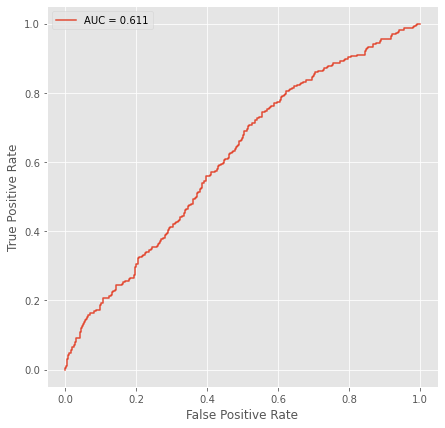

In [44]:
plot_auc(valY, pred_Y2)

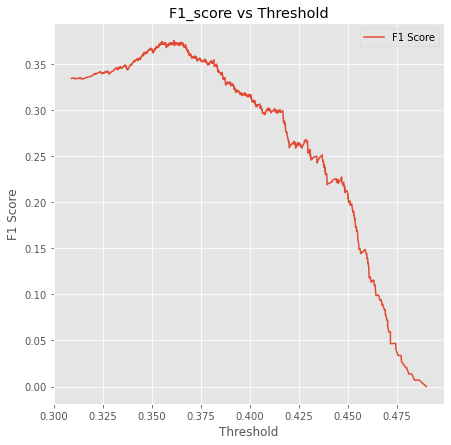

In [45]:
f1_plot(valY, pred_Y2)

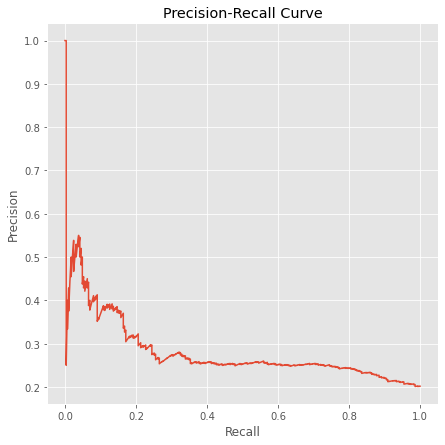

In [46]:
prec_recall_plot(valY, pred_Y2)

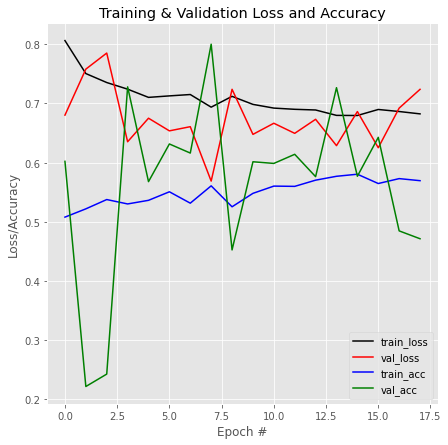

In [47]:
plot_history(hist2)

#### Comments: 

From the history plot, it can be seen that the model appears stable and very promising.

#### 4. Using only the last layer, adding dropouts and connecting 4 FC layers

In [48]:
vgg_model3 = load_pretrained_model()
vgg_model3.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [49]:
## using only the last output layer more dropouts and connecting 4 FC layer
## running for 10 epochs to see how if any learning occurs:
my_model3 = build_my_model(vgg_model3, 
                           end_layer_freeze_at = -1, 
                           specific_layer = None, 
                           fc_list = [1024, 512, 256, 128])
#my_model3.fit_generator(train_gen, 
#                       validation_data = (valX, valY), 
#                       epochs = int(num_epochs/4))

input_4 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool True


In [50]:
weight_path3="{}_my_model3.best.hdf5".format('pneumonia_class')

checkpoint3 = ModelCheckpoint(weight_path3, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early3 = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list3 = [checkpoint3, early3]

In [51]:
hist3 = my_model3.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = num_epochs, 
                           callbacks = callbacks_list3)

Epoch 1/50
72/72 [==============================] - 73s 1s/step - loss: 0.8341 - binary_accuracy: 0.5140 - val_loss: 0.6746 - val_binary_accuracy: 0.6510

Epoch 00001: val_loss improved from inf to 0.67458, saving model to pneumonia_class_my_model3.best.hdf5
Epoch 2/50
72/72 [==============================] - 64s 885ms/step - loss: 0.7736 - binary_accuracy: 0.5083 - val_loss: 0.6796 - val_binary_accuracy: 0.6119

Epoch 00002: val_loss did not improve from 0.67458
Epoch 3/50
72/72 [==============================] - 63s 869ms/step - loss: 0.7562 - binary_accuracy: 0.5148 - val_loss: 0.6186 - val_binary_accuracy: 0.8000

Epoch 00003: val_loss improved from 0.67458 to 0.61855, saving model to pneumonia_class_my_model3.best.hdf5
Epoch 4/50
72/72 [==============================] - 63s 872ms/step - loss: 0.7420 - binary_accuracy: 0.5157 - val_loss: 0.6562 - val_binary_accuracy: 0.7986

Epoch 00004: val_loss did not improve from 0.61855
Epoch 5/50
72/72 [==============================] - 64s 8

In [52]:
my_model3.load_weights(weight_path3)
pred_Y3 = my_model3.predict(valX, verbose = True)

1430/1430 [==============================] - 13s 9ms/step


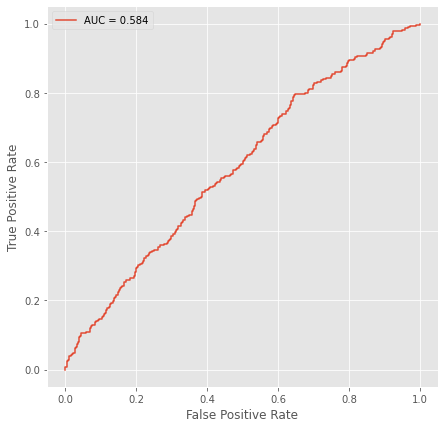

In [53]:
plot_auc(valY, pred_Y3)

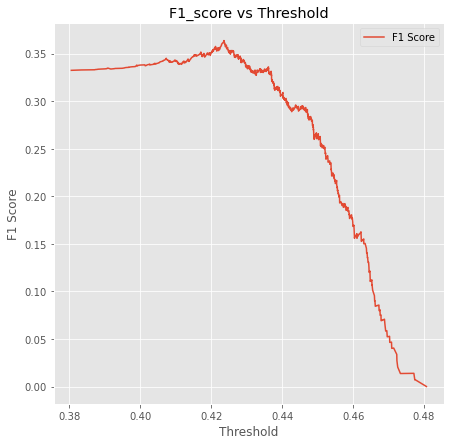

In [54]:
f1_plot(valY, pred_Y3)

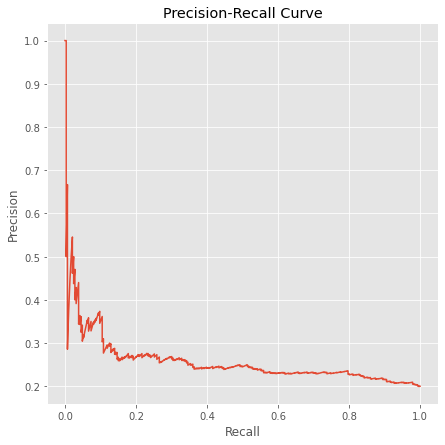

In [55]:
prec_recall_plot(valY, pred_Y3)

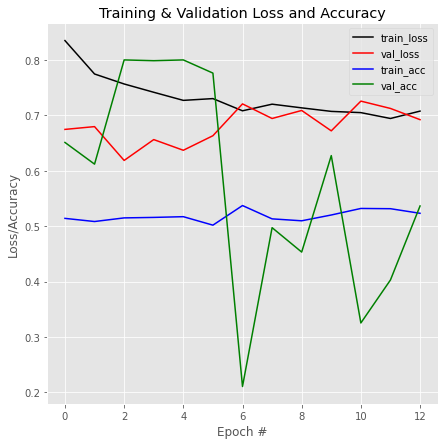

In [56]:
plot_history(hist3)

#### Comments: 

From the history plot, it can be seen that the model appears stable and promising. Lower performances than my_model2

#### 5. Using the 10th output layer, adding dropouts and connecting 3 FC layers (similar to my_model2)

In [57]:
vgg_model4 = load_pretrained_model()
vgg_model4.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [58]:
## using only the last output layer more dropouts and connecting 4 FC layer
## running for 10 epochs to see how if any learning occurs:
my_model4 = build_my_model(vgg_model4, 
                           end_layer_freeze_at = -1, 
                           specific_layer = 9, 
                           fc_list = [1024, 512, 256])
#my_model3.fit_generator(train_gen, 
#                       validation_data = (valX, valY), 
#                       epochs = int(num_epochs/4))

input_5 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 True
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [59]:
weight_path4="{}_my_model4.best.hdf5".format('pneumonia_class')

checkpoint4 = ModelCheckpoint(weight_path4, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early4 = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list4 = [checkpoint4, early4]

In [60]:
hist4 = my_model4.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = num_epochs, 
                           callbacks = callbacks_list4)

Epoch 1/50
72/72 [==============================] - 74s 1s/step - loss: 0.8006 - binary_accuracy: 0.5210 - val_loss: 0.6719 - val_binary_accuracy: 0.6119

Epoch 00001: val_loss improved from inf to 0.67188, saving model to pneumonia_class_my_model4.best.hdf5
Epoch 2/50
72/72 [==============================] - 66s 910ms/step - loss: 0.7665 - binary_accuracy: 0.5118 - val_loss: 0.5842 - val_binary_accuracy: 0.8000

Epoch 00002: val_loss improved from 0.67188 to 0.58416, saving model to pneumonia_class_my_model4.best.hdf5
Epoch 3/50
72/72 [==============================] - 65s 906ms/step - loss: 0.7306 - binary_accuracy: 0.5279 - val_loss: 0.6413 - val_binary_accuracy: 0.7909

Epoch 00003: val_loss did not improve from 0.58416
Epoch 4/50
72/72 [==============================] - 65s 902ms/step - loss: 0.7246 - binary_accuracy: 0.5236 - val_loss: 0.6447 - val_binary_accuracy: 0.6720

Epoch 00004: val_loss did not improve from 0.58416
Epoch 5/50
72/72 [==============================] - 65s 9

In [61]:
my_model4.load_weights(weight_path4)
pred_Y4 = my_model4.predict(valX, verbose = True)

1430/1430 [==============================] - 13s 9ms/step


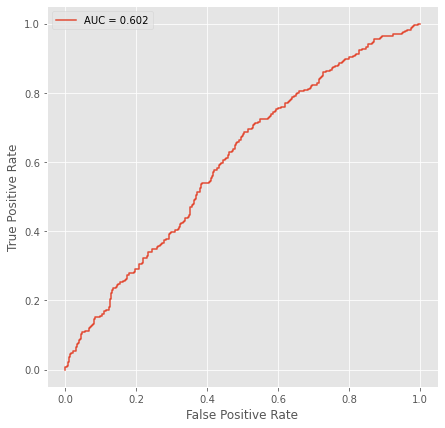

In [62]:
plot_auc(valY, pred_Y4)

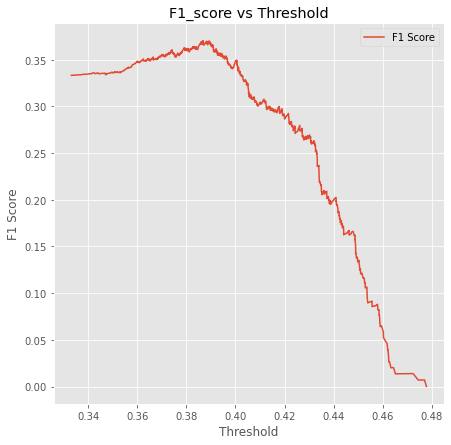

In [63]:
f1_plot(valY, pred_Y4)

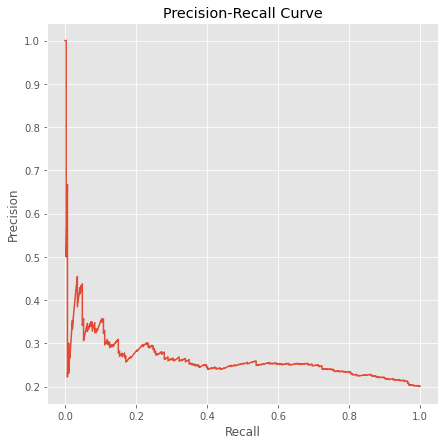

In [64]:
prec_recall_plot(valY, pred_Y4)

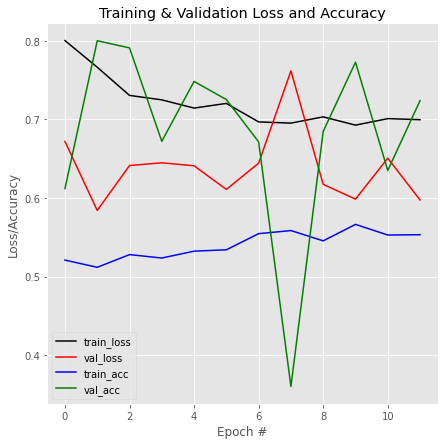

In [65]:
plot_history(hist4)

#### Comments:
Relatively stable model with performances comparable to my_model2. Using this last model for further analysis.  

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [67]:
# compute precision, recall and threshold using the "best" model
precision, recall, thresholds = precision_recall_curve(valY, pred_Y4)
# compute the best threshold
best_threshold = best_threshold(precision,recall)
# compute the corresponding f1_scores
f1_score = calc_f1(precision,recall)
print('f1_score @ best threshold: %.3f'%f1_score[np.nanargmax(f1_score)])

Threshold that maximized f1_score is: 0.387
Corresponding Precision is: 0.250
Recall is: 0.71
f1_score @ best threshold: 0.371


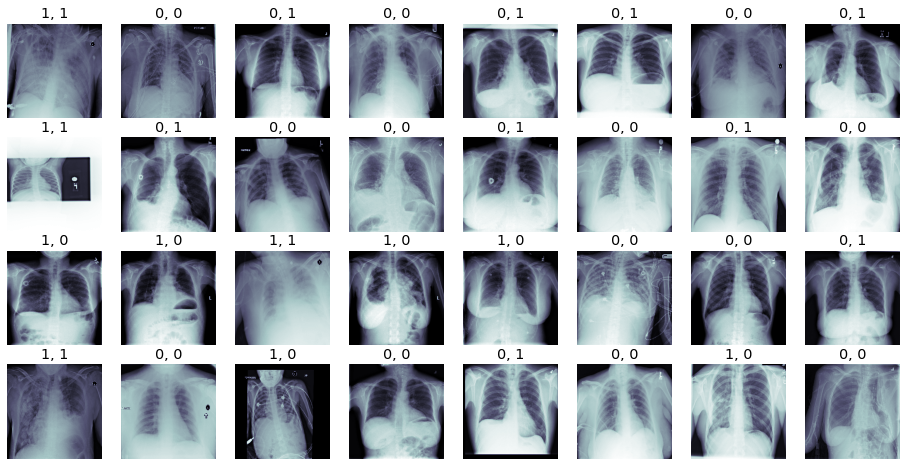

In [68]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

#best_threshold = best_threshold
YOUR_THRESHOLD = best_threshold

fig, m_axs = plt.subplots(4, 8, figsize = (16, 8))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:32], valY[0:32], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y4[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y4[i] < YOUR_THRESHOLD:
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1


In [69]:
## Just save model architecture to a .json:

model_json = my_model4.to_json()
with open("my_final_model.json", "w") as json_file:
    json_file.write(model_json)

### Model performance in the presence of other diseases that comorbid with pneumonia

From the EDA, the top 5 disease that cormobid with pneumonia are Atelectasis, Effusion, Edema, Infiltration and Consolidation.

In [70]:
val_data['predicted'] = pred_Y4
val_data['predictions'] = val_data.apply(lambda df: 1.0 if df['predicted'] >= YOUR_THRESHOLD else 0.0, axis=1)
val_data.sample(3, random_state = random_state)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,predicted,predictions
50750,00012834_155.png,Consolidation|Edema|Infiltration|Pleural_Thick...,155,12834,34,M,AP,2500,2048,0.168,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1,0.443520,1.0
104425,00027927_017.png,Effusion,17,27927,58,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.391650,1.0
74571,00018305_001.png,No Finding,1,18305,31,F,PA,2906,2989,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.374772,0.0


In [71]:
# compute the positives & negatives predicted
tn, fp, fn, tp = confusion_matrix(val_data.Pneumonia.values,
                                                  val_data.predictions.values,labels=[0,1]).ravel()

In [72]:
# check model's performance without other diseases
sens = tp/(tp+fn)
spec = tn/(tn+fp)
print('sensitivity = %.4f'%sens)
print('specificity = %.4f'%spec)

sensitivity = 0.6119
specificity = 0.4406


Now, let's look at the algorithm's performance in the presence of the other diseases: 

In [73]:
for item in ['Atelectasis','Effusion','Edema','Infiltration','Consolidation']:  # top 5 diseases that cormobid with pneumonia

    tn, fp, fn, tp = confusion_matrix(val_data[val_data[item] == 1].Pneumonia.values,
                                                  val_data[val_data[item] == 1].predictions.values,labels=[0,1]).ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    print(item)
    print('sensitivity = %.4f'%sens)
    print('specificity = %.4f'%spec)
    print()

Atelectasis
sensitivity = 0.5106
specificity = 0.4228

Effusion
sensitivity = 0.4444
specificity = 0.5036

Edema
sensitivity = 0.4906
specificity = 0.6000

Infiltration
sensitivity = 0.6239
specificity = 0.4475

Consolidation
sensitivity = 0.7241
specificity = 0.5800



#### Algorithm's limitations:

The results show that the presence edema, effusion and atelectasis lower the performance of this algorithm at accurately predicting pneumonia. The presence of infiltration slightly impacts the algorithm's algorithm's sensitivty and specificity. The algorithm's performances at accurately predicting pneumonia are improved by the presence of consolidation. The presence of any of the effusion, edema and consolidation affects the algorithm's specificity and may increase the number of false positives.  

#### References:
    1. https://www.kaggle.com/kmader/train-simple-xray-cnn
    2. https://www.kaggle.com/kmader/cardiomegaly-pretrained-vgg16
    3. https://arxiv.org/pdf/1711.05225.pdf
    4. https://arxiv.org/pdf/1710.10501.pdf
    5. https://arxiv.org/pdf/1705.02315.pdf
    6. https://lukeoakdenrayner.wordpress.com/2018/01/24/chexnet-an-in-depth-review/